In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from google.colab import drive
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.csv("Obesity prediction.csv", header=True, inferSchema=True, sep=",")
df.show(5, truncate=False)

+------+----+------+------+--------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Gender|Age |Height|Weight|family_history|FAVC|FCVC|NCP|CAEC     |SMOKE|CH2O|SCC|FAF|TUE|CALC      |MTRANS               |Obesity            |
+------+----+------+------+--------------+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Female|21.0|1.62  |64.0  |yes           |no  |2.0 |3.0|Sometimes|no   |2.0 |no |0.0|1.0|no        |Public_Transportation|Normal_Weight      |
|Female|21.0|1.52  |56.0  |yes           |no  |3.0 |3.0|Sometimes|yes  |3.0 |yes|3.0|0.0|Sometimes |Public_Transportation|Normal_Weight      |
|Male  |23.0|1.8   |77.0  |yes           |no  |2.0 |3.0|Sometimes|no   |2.0 |no |2.0|1.0|Frequently|Public_Transportation|Normal_Weight      |
|Male  |27.0|1.8   |87.0  |no            |no  |3.0 |3.0|Sometimes|no   |2.0 |no |2.0|0.0|Frequently|Walking              |Overweight_Level_I |

**PREPROCESSING**

In [ ]:
#Drop kolom yang tidak dipakai
data = df.drop("FCVC", "TUE", "MTRANS")
data.show(5)

+------+----+------+------+--------------+----+---+---------+-----+----+---+---+----------+-------------------+
|Gender| Age|Height|Weight|family_history|FAVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|      CALC|            Obesity|
+------+----+------+------+--------------+----+---+---------+-----+----+---+---+----------+-------------------+
|Female|21.0|  1.62|  64.0|           yes|  no|3.0|Sometimes|   no| 2.0| no|0.0|        no|      Normal_Weight|
|Female|21.0|  1.52|  56.0|           yes|  no|3.0|Sometimes|  yes| 3.0|yes|3.0| Sometimes|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|           yes|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|            no|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently| Overweight_Level_I|
|  Male|22.0|  1.78|  89.8|            no|  no|1.0|Sometimes|   no| 2.0| no|0.0| Sometimes|Overweight_Level_II|
+------+----+------+------+--------------+----+---+---------+-----+----+---+---+----------+-------------

In [ ]:
#Merubah nama kolom
data = data.toDF(*[col_name.lower() for col_name in data.columns])

data = data.withColumnRenamed("family_history", "fh")

data.show(5)

+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+-------------------+
|gender| age|height|weight| fh|favc|ncp|     caec|smoke|ch2o|scc|faf|      calc|            obesity|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+-------------------+
|Female|21.0|  1.62|  64.0|yes|  no|3.0|Sometimes|   no| 2.0| no|0.0|        no|      Normal_Weight|
|Female|21.0|  1.52|  56.0|yes|  no|3.0|Sometimes|  yes| 3.0|yes|3.0| Sometimes|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|yes|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|      Normal_Weight|
|  Male|27.0|   1.8|  87.0| no|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently| Overweight_Level_I|
|  Male|22.0|  1.78|  89.8| no|  no|1.0|Sometimes|   no| 2.0| no|0.0| Sometimes|Overweight_Level_II|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+-------------------+
only showing top 5 rows



In [ ]:
#Memeriksa tipe data
data.dtypes

[('gender', 'string'),
 ('age', 'double'),
 ('height', 'double'),
 ('weight', 'double'),
 ('fh', 'string'),
 ('favc', 'string'),
 ('ncp', 'double'),
 ('caec', 'string'),
 ('smoke', 'string'),
 ('ch2o', 'double'),
 ('scc', 'string'),
 ('faf', 'double'),
 ('calc', 'string'),
 ('obesity', 'string')]

In [ ]:
#Memeriksa nilai null
from pyspark.sql.functions import isnan, when, count

data.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in data.columns]).show()

+------+---+------+------+---+----+---+----+-----+----+---+---+----+-------+
|gender|age|height|weight| fh|favc|ncp|caec|smoke|ch2o|scc|faf|calc|obesity|
+------+---+------+------+---+----+---+----+-----+----+---+---+----+-------+
|     0|  0|     0|     0|  0|   0|  0|   0|    0|   0|  0|  0|   0|      0|
+------+---+------+------+---+----+---+----+-----+----+---+---+----+-------+



In [ ]:
#Menampilkan summary
data.describe().show()

+-------+------+-----------------+-------------------+------------------+----+----+------------------+------+-----+------------------+----+------------------+------+-------------------+
|summary|gender|              age|             height|            weight|  fh|favc|               ncp|  caec|smoke|              ch2o| scc|               faf|  calc|            obesity|
+-------+------+-----------------+-------------------+------------------+----+----+------------------+------+-----+------------------+----+------------------+------+-------------------+
|  count|  2111|             2111|               2111|              2111|2111|2111|              2111|  2111| 2111|              2111|2111|              2111|  2111|               2111|
|   mean|  NULL|24.31259990857412| 1.7016773533870178| 86.58605812648037|NULL|NULL| 2.685628049739461|  NULL| NULL|   2.0080114040739|NULL| 1.010297695878732|  NULL|               NULL|
| stddev|  NULL|6.345968273732226|0.09330481986792012|26.1911717452047

In [ ]:
#Pemisahan dataset menjadi dua, features dan label
data_features = data.select("gender", "age", "height", "weight", "fh", "favc", "ncp", "caec", "smoke", "ch2o", "scc", "faf", "calc")
data_label = data.select("obesity")

print("DATA FEATURES")
data_features.show(5)
print("DATA LABEL")
data_label.show(5)

DATA FEATURES
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
|gender| age|height|weight| fh|favc|ncp|     caec|smoke|ch2o|scc|faf|      calc|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
|Female|21.0|  1.62|  64.0|yes|  no|3.0|Sometimes|   no| 2.0| no|0.0|        no|
|Female|21.0|  1.52|  56.0|yes|  no|3.0|Sometimes|  yes| 3.0|yes|3.0| Sometimes|
|  Male|23.0|   1.8|  77.0|yes|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|
|  Male|27.0|   1.8|  87.0| no|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|
|  Male|22.0|  1.78|  89.8| no|  no|1.0|Sometimes|   no| 2.0| no|0.0| Sometimes|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
only showing top 5 rows

DATA LABEL
+-------------------+
|            obesity|
+-------------------+
|      Normal_Weight|
|      Normal_Weight|
|      Normal_Weight|
| Overweight_Level_I|
|Overweight_Level_II|
+-------------------+
only showing top 5 rows

In [ ]:
#MEMPROSES DATA FEATURES

In [ ]:
data_features.show(5)

+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
|gender| age|height|weight| fh|favc|ncp|     caec|smoke|ch2o|scc|faf|      calc|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
|Female|21.0|  1.62|  64.0|yes|  no|3.0|Sometimes|   no| 2.0| no|0.0|        no|
|Female|21.0|  1.52|  56.0|yes|  no|3.0|Sometimes|  yes| 3.0|yes|3.0| Sometimes|
|  Male|23.0|   1.8|  77.0|yes|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|
|  Male|27.0|   1.8|  87.0| no|  no|3.0|Sometimes|   no| 2.0| no|2.0|Frequently|
|  Male|22.0|  1.78|  89.8| no|  no|1.0|Sometimes|   no| 2.0| no|0.0| Sometimes|
+------+----+------+------+---+----+---+---------+-----+----+---+---+----------+
only showing top 5 rows



In [ ]:
#Pemisahan data features menjadi dua, numerik dan kategorikal
numerical_data = data_features.select("age", "height", "weight", "ncp", "ch2o", "faf")
categorical_data = data_features.select("gender", "fh", "favc", "caec", "smoke", "scc", "calc")

print("DATA NUMERIK")
numerical_data.show(5)
print("DATA KATEGORIKAL")
categorical_data.show(5)

DATA NUMERIK
+----+------+------+---+----+---+
| age|height|weight|ncp|ch2o|faf|
+----+------+------+---+----+---+
|21.0|  1.62|  64.0|3.0| 2.0|0.0|
|21.0|  1.52|  56.0|3.0| 3.0|3.0|
|23.0|   1.8|  77.0|3.0| 2.0|2.0|
|27.0|   1.8|  87.0|3.0| 2.0|2.0|
|22.0|  1.78|  89.8|1.0| 2.0|0.0|
+----+------+------+---+----+---+
only showing top 5 rows

DATA KATEGORIKAL
+------+---+----+---------+-----+---+----------+
|gender| fh|favc|     caec|smoke|scc|      calc|
+------+---+----+---------+-----+---+----------+
|Female|yes|  no|Sometimes|   no| no|        no|
|Female|yes|  no|Sometimes|  yes|yes| Sometimes|
|  Male|yes|  no|Sometimes|   no| no|Frequently|
|  Male| no|  no|Sometimes|   no| no|Frequently|
|  Male| no|  no|Sometimes|   no| no| Sometimes|
+------+---+----+---------+-----+---+----------+
only showing top 5 rows



In [ ]:
#Normalisasi data numerik

In [ ]:
#Normalisasi data numerik dengan Min-Max Scaling
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

assembler = VectorAssembler(inputCols=numerical_data.columns, outputCol="features")
numerical_data = assembler.transform(numerical_data)

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(numerical_data)
scaled_numerical = scaler_model.transform(numerical_data)

In [ ]:
scaled_numerical_fix = scaled_numerical.select("scaled_features")

print("HASIL NORMALISASI")
scaled_numerical_fix.show(5, truncate=False)

HASIL NORMALISASI
+-----------------------------------------------------------------------------------------------------+
|scaled_features                                                                                      |
+-----------------------------------------------------------------------------------------------------+
|[0.14893617021276595,0.32075471698113234,0.18656716417910446,0.6666666666666666,0.5,0.0]             |
|[0.14893617021276595,0.13207547169811332,0.12686567164179105,0.6666666666666666,1.0,1.0]             |
|[0.19148936170212766,0.6603773584905661,0.2835820895522388,0.6666666666666666,0.5,0.6666666666666666]|
|[0.2765957446808511,0.6603773584905661,0.3582089552238806,0.6666666666666666,0.5,0.6666666666666666] |
|[0.1702127659574468,0.6226415094339623,0.37910447761194027,0.0,0.5,0.0]                              |
+-----------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
scaled_numerical_fix.printSchema()

root
 |-- scaled_features: vector (nullable = true)



In [ ]:
#Encoding data kategorikal

In [ ]:
#Memisahkan dataset kategorikal menjadi kategorikal nominal dan kategorikal ordinal
categorical_nominal = categorical_data.select("gender", "fh", "favc", "smoke", "scc")
categorical_ordinal = categorical_data.select("caec", "calc")

print("DATA KATEGORIKAL NOMINAL")
categorical_nominal.show(5)
print("DATA KATEGORIKAL ORDINAL")
categorical_ordinal.show(5)

DATA KATEGORIKAL NOMINAL
+------+---+----+-----+---+
|gender| fh|favc|smoke|scc|
+------+---+----+-----+---+
|Female|yes|  no|   no| no|
|Female|yes|  no|  yes|yes|
|  Male|yes|  no|   no| no|
|  Male| no|  no|   no| no|
|  Male| no|  no|   no| no|
+------+---+----+-----+---+
only showing top 5 rows

DATA KATEGORIKAL ORDINAL
+---------+----------+
|     caec|      calc|
+---------+----------+
|Sometimes|        no|
|Sometimes| Sometimes|
|Sometimes|Frequently|
|Sometimes|Frequently|
|Sometimes| Sometimes|
+---------+----------+
only showing top 5 rows



In [ ]:
#Encoding data kategorikal nominal dengan One-Hot Encoder
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexers = []
encoders = []

for col in categorical_nominal.columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    indexers.append(indexer)

    encoder = OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_onehot")
    encoders.append(encoder)

pipeline_nominal = Pipeline(stages=indexers + encoders)

model_nominal = pipeline_nominal.fit(categorical_nominal)
encoded_nominal = model_nominal.transform(categorical_nominal)

In [ ]:
encoded_nominal.show(5)

+------+---+----+-----+---+--------------+----------+------------+-------------+-----------+-------------+-------------+-----------+-------------+-------------+
|gender| fh|favc|smoke|scc|gender_indexed|fh_indexed|favc_indexed|smoke_indexed|scc_indexed|gender_onehot|    fh_onehot|favc_onehot| smoke_onehot|   scc_onehot|
+------+---+----+-----+---+--------------+----------+------------+-------------+-----------+-------------+-------------+-----------+-------------+-------------+
|Female|yes|  no|   no| no|           1.0|       0.0|         1.0|          0.0|        0.0|    (1,[],[])|(1,[0],[1.0])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|
|Female|yes|  no|  yes|yes|           1.0|       0.0|         1.0|          1.0|        1.0|    (1,[],[])|(1,[0],[1.0])|  (1,[],[])|    (1,[],[])|    (1,[],[])|
|  Male|yes|  no|   no| no|           0.0|       0.0|         1.0|          0.0|        0.0|(1,[0],[1.0])|(1,[0],[1.0])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|
|  Male| no|  no|   no| no|       

In [ ]:
encoded_nominal_fix = encoded_nominal.select("gender_onehot", "fh_onehot", "favc_onehot", "smoke_onehot", "scc_onehot", )

print("HASIL ENCODING")
encoded_nominal_fix.show(5, truncate=False)

HASIL ENCODING
+-------------+-------------+-----------+-------------+-------------+
|gender_onehot|fh_onehot    |favc_onehot|smoke_onehot |scc_onehot   |
+-------------+-------------+-----------+-------------+-------------+
|(1,[],[])    |(1,[0],[1.0])|(1,[],[])  |(1,[0],[1.0])|(1,[0],[1.0])|
|(1,[],[])    |(1,[0],[1.0])|(1,[],[])  |(1,[],[])    |(1,[],[])    |
|(1,[0],[1.0])|(1,[0],[1.0])|(1,[],[])  |(1,[0],[1.0])|(1,[0],[1.0])|
|(1,[0],[1.0])|(1,[],[])    |(1,[],[])  |(1,[0],[1.0])|(1,[0],[1.0])|
|(1,[0],[1.0])|(1,[],[])    |(1,[],[])  |(1,[0],[1.0])|(1,[0],[1.0])|
+-------------+-------------+-----------+-------------+-------------+
only showing top 5 rows



In [ ]:
encoded_nominal_fix.printSchema()

root
 |-- gender_onehot: vector (nullable = true)
 |-- fh_onehot: vector (nullable = true)
 |-- favc_onehot: vector (nullable = true)
 |-- smoke_onehot: vector (nullable = true)
 |-- scc_onehot: vector (nullable = true)



In [ ]:
#Encoding data kategorikal ordinal dengan Ordinal Encoding
from pyspark.ml.feature import StringIndexer

indexers_ordinal = []

for col in categorical_ordinal.columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    indexers_ordinal.append(indexer)

pipeline_ordinal = Pipeline(stages=indexers_ordinal)

model_ordinal = pipeline_ordinal.fit(categorical_ordinal)
encoded_ordinal = model_ordinal.transform(categorical_ordinal)

In [ ]:
encoded_ordinal_fix = encoded_ordinal.select("caec_index", "calc_index")

print("HASIL ENCODING")
encoded_ordinal_fix.show(5, truncate=False)

HASIL ENCODING
+----------+----------+
|caec_index|calc_index|
+----------+----------+
|0.0       |1.0       |
|0.0       |0.0       |
|0.0       |2.0       |
|0.0       |2.0       |
|0.0       |0.0       |
+----------+----------+
only showing top 5 rows



In [ ]:
encoded_ordinal_fix.printSchema()

root
 |-- caec_index: double (nullable = false)
 |-- calc_index: double (nullable = false)



In [ ]:
#Menggabungkan dataset hasil normalisasi dan encoding
from pyspark.sql.functions import monotonically_increasing_id

scaled_numerical_fix = scaled_numerical_fix.withColumn("id", monotonically_increasing_id())
encoded_nominal_fix = encoded_nominal_fix.withColumn("id", monotonically_increasing_id())
encoded_ordinal_fix = encoded_ordinal_fix.withColumn("id", monotonically_increasing_id())

merged_dataset = scaled_numerical_fix.join(encoded_nominal_fix, on="id").join(encoded_ordinal_fix, on="id")

In [ ]:
merged_dataset.show(5)

+---+--------------------+-------------+-------------+-----------+-------------+-------------+----------+----------+
| id|     scaled_features|gender_onehot|    fh_onehot|favc_onehot| smoke_onehot|   scc_onehot|caec_index|calc_index|
+---+--------------------+-------------+-------------+-----------+-------------+-------------+----------+----------+
|  0|[0.14893617021276...|    (1,[],[])|(1,[0],[1.0])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|       0.0|       1.0|
|  1|[0.14893617021276...|    (1,[],[])|(1,[0],[1.0])|  (1,[],[])|    (1,[],[])|    (1,[],[])|       0.0|       0.0|
|  2|[0.19148936170212...|(1,[0],[1.0])|(1,[0],[1.0])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|       0.0|       2.0|
|  3|[0.27659574468085...|(1,[0],[1.0])|    (1,[],[])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|       0.0|       2.0|
|  4|[0.17021276595744...|(1,[0],[1.0])|    (1,[],[])|  (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|       0.0|       0.0|
+---+--------------------+-------------+-------------+----------

In [ ]:
#Menggabungkan kolom2
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["scaled_features", "gender_onehot", "fh_onehot", "favc_onehot", "smoke_onehot", "scc_onehot", "caec_index", "calc_index"],
    outputCol="features"
)

merged_transform = assembler.transform(merged_dataset)

In [ ]:
data_features_fix = merged_transform.select("id", "features")
data_features_fix.show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                         |
+---+---------------------------------------------------------------------------------------------------------------------------------+
|0  |[0.14893617021276595,0.32075471698113234,0.18656716417910446,0.6666666666666666,0.5,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0]             |
|1  |(13,[0,1,2,3,4,5,7],[0.14893617021276595,0.13207547169811332,0.12686567164179105,0.6666666666666666,1.0,1.0,1.0])                |
|2  |[0.19148936170212766,0.6603773584905661,0.2835820895522388,0.6666666666666666,0.5,0.6666666666666666,1.0,1.0,0.0,1.0,1.0,0.0,2.0]|
|3  |[0.2765957446808511,0.6603773584905661,0.3582089552238806,0.6666666666666666,0.5,0.6666666666666666,1.0,0.0,0.0,1.0,1.0,0.0,2.0] |
|4  |(13,[0,1,2,4,6,9,10],[0.1702127659574468,0.

In [ ]:
data_features_fix.printSchema()

root
 |-- id: long (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
#MEMPROSES DATA LABEL

In [ ]:
data_label.show(5)

+-------------------+
|            obesity|
+-------------------+
|      Normal_Weight|
|      Normal_Weight|
|      Normal_Weight|
| Overweight_Level_I|
|Overweight_Level_II|
+-------------------+
only showing top 5 rows



In [ ]:
data_label.printSchema()

root
 |-- obesity: string (nullable = true)



In [ ]:
#Merubah string ke numerik
from pyspark.ml.feature import StringIndexer

indexers_label = []

for col in data_label.columns:
    indexer = StringIndexer(inputCol=col, outputCol="label")
    indexers_label.append(indexer)

pipeline_label = Pipeline(stages=indexers_label)

model_label = pipeline_label.fit(data_label)
encoded_label = model_label.transform(data_label)

In [ ]:
data_label = encoded_label.select("label")
data_label.show(5, truncate=False)

+-----+
|label|
+-----+
|5.0  |
|5.0  |
|5.0  |
|3.0  |
|4.0  |
+-----+
only showing top 5 rows



In [ ]:
#Menambahkan kolom id
from pyspark.sql.functions import monotonically_increasing_id

data_label_fix = data_label.withColumn("id", monotonically_increasing_id())

In [ ]:
data_label_fix.show(5)

+-----+---+
|label| id|
+-----+---+
|  5.0|  0|
|  5.0|  1|
|  5.0|  2|
|  3.0|  3|
|  4.0|  4|
+-----+---+
only showing top 5 rows



In [ ]:
data_label_fix.printSchema()

root
 |-- label: double (nullable = false)
 |-- id: long (nullable = false)



In [ ]:
#Menggabungkan data features dix dan data label fix
data_fix = data_features_fix.join(data_label_fix, on="id")

In [ ]:
data_fix = data_fix.select("features", "label")
data_fix.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.14893617021276...|  5.0|
|(13,[0,1,2,3,4,5,...|  5.0|
|[0.19148936170212...|  5.0|
|[0.27659574468085...|  3.0|
|(13,[0,1,2,4,6,9,...|  4.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
data_fix.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
#MODELLING

In [ ]:
#Bagi dua data jadi train dan test
train_data, test_data = data_fix.randomSplit([0.8, 0.2], seed=42)

In [ ]:
data_fix.filter(data_fix.features.isNull()).show()

+--------+-----+
|features|label|
+--------+-----+
+--------+-----+



In [ ]:
data_fix.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  351|
|  1.0|  324|
|  4.0|  290|
|  3.0|  290|
|  2.0|  297|
|  6.0|  272|
|  5.0|  287|
+-----+-----+



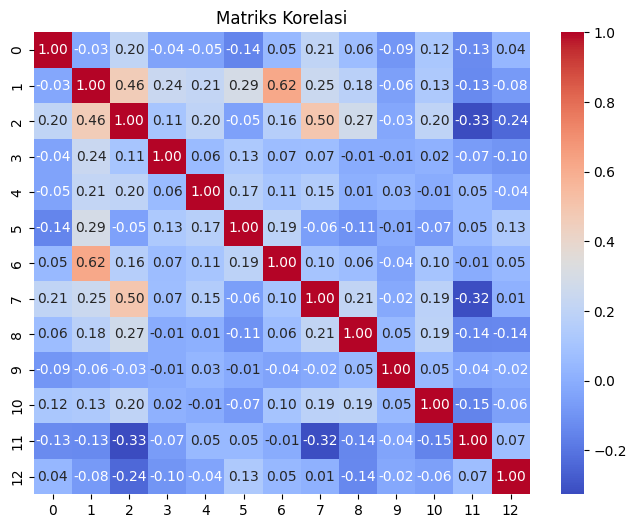

In [ ]:
#Matriks Korelasi
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_matrix = Correlation.corr(data_fix, "features").head()[0]

correlation_array = correlation_matrix.toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_array, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

**EDA**

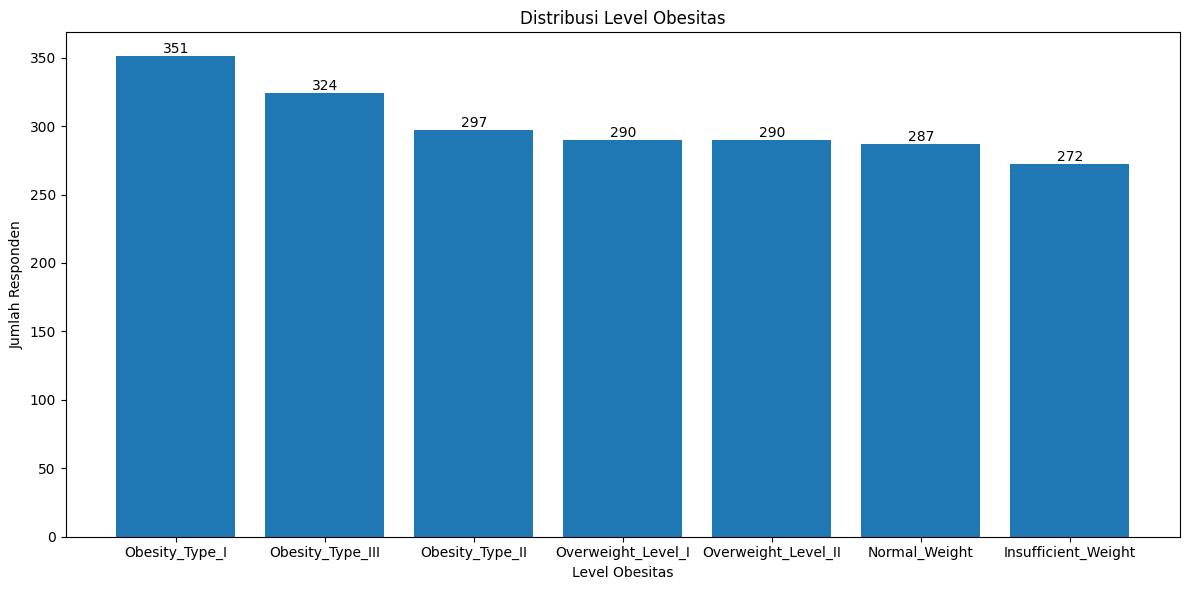

In [ ]:
#Bar Chart - Distribusi Level Obesitas
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

obesity_counts = df.groupBy('Obesity').count().orderBy('count', ascending=False).collect()

labels = [row['Obesity'] for row in obesity_counts]
values = [row['count'] for row in obesity_counts]

plt.figure(figsize=(12, 6))
plt.bar(labels, values)

plt.title('Distribusi Level Obesitas')
plt.xlabel('Level Obesitas')
plt.ylabel('Jumlah Responden')

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()

plt.show()


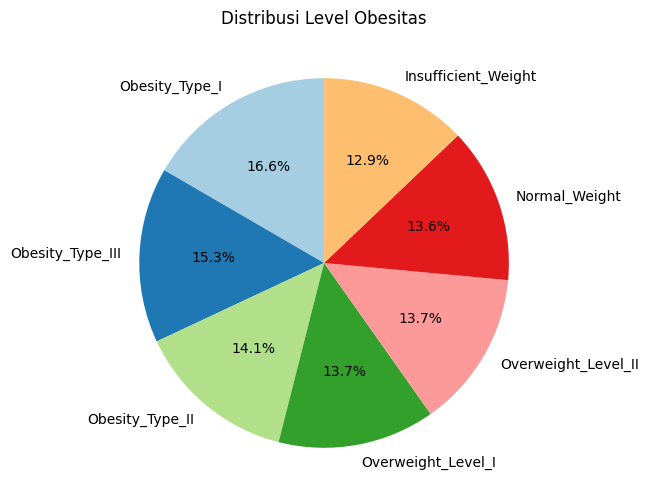

In [ ]:
#Pie Chart - Distribusi Level Obesitas
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

obesity_counts = df.groupBy('Obesity').count().orderBy('count', ascending=False).collect()

labels = [row['Obesity'] for row in obesity_counts]
values = [row['count'] for row in obesity_counts]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

plt.title('Distribusi Level Obesitas')

plt.show()


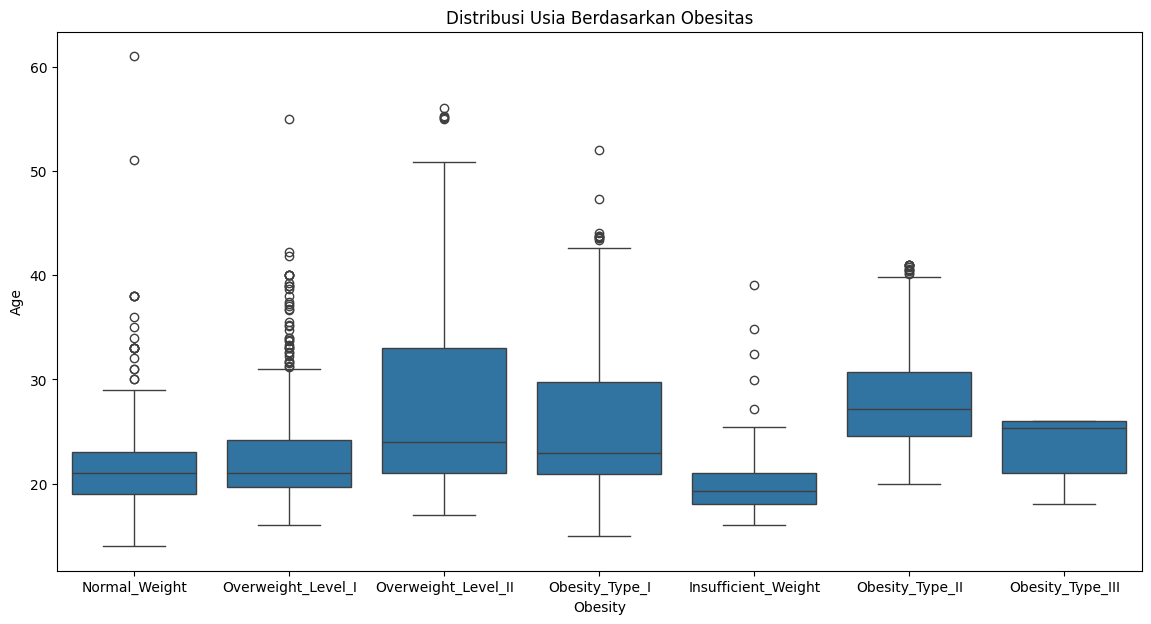

In [ ]:
#Box Plot - Distribusi Age pada Obesity
pdf = df.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.boxplot(x='Obesity', y='Age', data=pdf)
plt.title('Distribusi Usia Berdasarkan Obesitas')
plt.xlabel('Obesity')
plt.ylabel('Age')
plt.show()

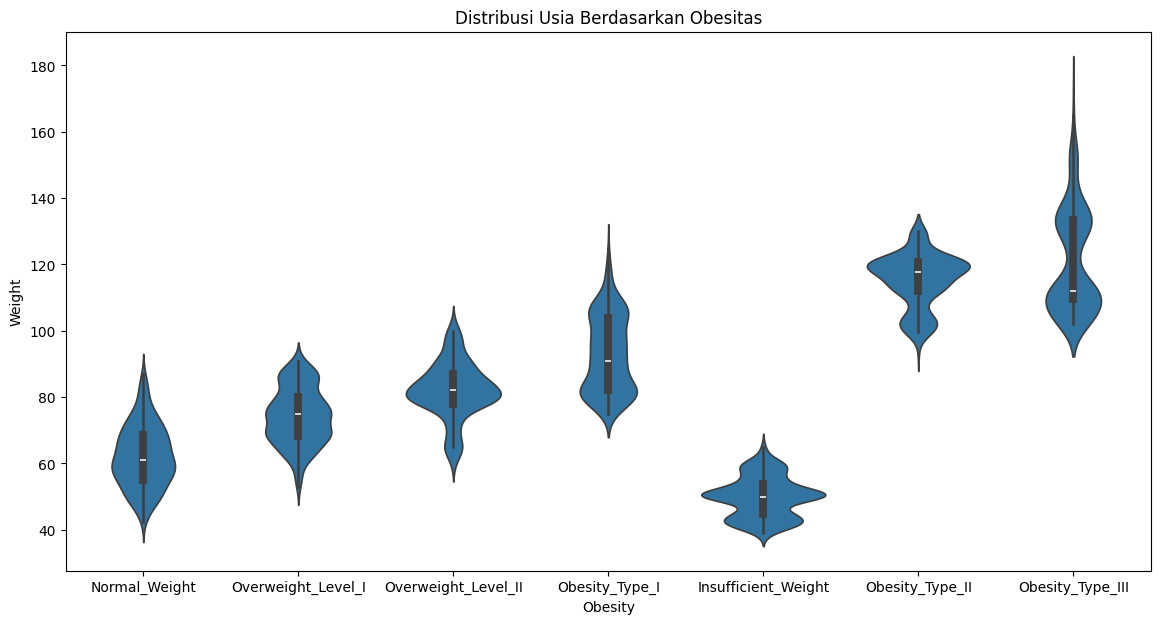

In [ ]:
#Violin Plot - Distribusi Weight pada Obesity
pdf = df.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.violinplot(x='Obesity', y='Weight', data=pdf)
plt.title('Distribusi Usia Berdasarkan Obesitas')
plt.xlabel('Obesity')
plt.ylabel('Weight')
plt.show()

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

numerical_cols = ['age', 'height', 'weight', 'ncp', 'ch2o', 'faf']
categorical_cols = ['gender', 'fh', 'favc', 'caec', 'smoke', 'scc', 'calc', 'obesity']

indexer = StringIndexer(inputCol='obesity', outputCol='obesity_label')
data = indexer.fit(data).transform(data)

data = data.withColumn('obesity_label', when(data['obesity_label'] > 1, 1).otherwise(0))

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(data)
    for col in categorical_cols if col != 'obesity'
]

feature_cols = numerical_cols + [f"{col}_index" for col in categorical_cols if col != 'obesity']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

svm = LinearSVC(featuresCol="scaled_features", labelCol="obesity_label", maxIter=10, regParam=0.1)

pipeline = Pipeline(stages=indexers + [assembler, scaler, svm])
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="obesity_label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

predictions.select("obesity", "obesity_label", "prediction").show(10)


Accuracy: 0.8817204301075269
+-------------------+-------------+----------+
|            obesity|obesity_label|prediction|
+-------------------+-------------+----------+
|      Normal_Weight|            1|       1.0|
|      Normal_Weight|            1|       1.0|
|     Obesity_Type_I|            0|       1.0|
| Overweight_Level_I|            1|       1.0|
|Insufficient_Weight|            1|       1.0|
| Overweight_Level_I|            1|       1.0|
| Overweight_Level_I|            1|       1.0|
|Insufficient_Weight|            1|       1.0|
|Insufficient_Weight|            1|       1.0|
|Insufficient_Weight|            1|       1.0|
+-------------------+-------------+----------+
only showing top 10 rows



In [ ]:
data = data.drop('obesity_label')

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import FMClassifier, GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

numerical_cols = ['age', 'height', 'weight', 'ncp', 'ch2o', 'faf']
categorical_cols = ['gender', 'fh', 'favc', 'caec', 'smoke', 'scc', 'calc', 'obesity']

# Index the target column
indexer = StringIndexer(inputCol='obesity', outputCol='obesity_label')
data = indexer.fit(data).transform(data)

# Binarize the obesity label for binary classification
data = data.withColumn('obesity_label', when(data['obesity_label'] > 2, 0).otherwise(1))

# Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(data)
    for col in categorical_cols if col != 'obesity'
]

# Combine numerical and indexed categorical columns into feature columns
feature_cols = numerical_cols + [f"{col}_index" for col in categorical_cols if col != 'obesity']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Standardize the feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the models
fm = FMClassifier(featuresCol="scaled_features", labelCol="obesity_label", stepSize=0.1, factorSize=10, maxIter=100)
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="obesity_label", maxIter=100, maxDepth=5, stepSize=0.1, seed=42)
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="obesity_label", numTrees=100, maxDepth=10, seed=42)
svm = LinearSVC(featuresCol="scaled_features", labelCol="obesity_label", maxIter=10, regParam=0.1)

models = {
    "FMClassifier": fm,
    "GBTClassifier": gbt,
    "RandomForestClassifier": rf,
    "LinearSVC": svm
}

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Evaluate each model
results = []
for model_name, model in models.items():
    pipeline = Pipeline(stages=indexers + [assembler, scaler, model])
    pipeline_model = pipeline.fit(train_data)
    predictions = pipeline_model.transform(test_data)

    evaluator_accuracy = MulticlassClassificationEvaluator(
        labelCol="obesity_label", predictionCol="prediction", metricName="accuracy"
    )
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="obesity_label", predictionCol="prediction", metricName="f1"
    )
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="obesity_label", predictionCol="prediction", metricName="weightedPrecision"
    )
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="obesity_label", predictionCol="prediction", metricName="weightedRecall"
    )
    binary_evaluator_auc = BinaryClassificationEvaluator(
        labelCol="obesity_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
    )

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc = binary_evaluator_auc.evaluate(predictions)

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    })

# Display results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"  Accuracy: {result['Accuracy']}")
    print(f"  F1 Score: {result['F1 Score']}")
    print(f"  Precision: {result['Precision']}")
    print(f"  Recall: {result['Recall']}")
    print(f"  AUC (ROC): {result['AUC']}")
    print("-")

Model: FMClassifier
  Accuracy: 0.9166666666666666
  F1 Score: 0.9166395663956639
  Precision: 0.919600173837462
  Recall: 0.9166666666666666
  AUC (ROC): 0.9807002314814806
-
Model: GBTClassifier
  Accuracy: 0.9946236559139785
  F1 Score: 0.9946236559139785
  Precision: 0.9946236559139785
  Recall: 0.9946236559139785
  AUC (ROC): 0.9970920138888889
-
Model: RandomForestClassifier
  Accuracy: 0.9946236559139785
  F1 Score: 0.9946225665456223
  Precision: 0.9946790821416694
  Recall: 0.9946236559139785
  AUC (ROC): 0.9997974537037037
-
Model: LinearSVC
  Accuracy: 0.9758064516129032
  F1 Score: 0.9758041760557711
  Precision: 0.9758160224920329
  Recall: 0.9758064516129032
  AUC (ROC): 0.9956886574074072
-


In [ ]:
data = data.drop('obesity_label')

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define evaluators
multiclass_evaluator = MulticlassClassificationEvaluator(
    labelCol="obesity_label", predictionCol="prediction", metricName="accuracy"
)

# Define GBTClassifier and RandomForestClassifier
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="obesity_label", seed=42)
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="obesity_label", seed=42)

# Definisi parameter untuk HyperParameterTuning
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [50, 100, 150]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2]) \
    .build()

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64, 128]) \
    .build()

# Define CrossValidator for GBTClassifier
gbt_cv = CrossValidator(
    estimator=Pipeline(stages=indexers + [assembler, scaler, gbt]),
    estimatorParamMaps=gbt_param_grid,
    evaluator=multiclass_evaluator,
    numFolds=5  # 5-fold cross-validation
)

# Define CrossValidator for RandomForestClassifier
rf_cv = CrossValidator(
    estimator=Pipeline(stages=indexers + [assembler, scaler, rf]),
    estimatorParamMaps=rf_param_grid,
    evaluator=multiclass_evaluator,
    numFolds=5  # 5-fold cross-validation
)

# Fit CrossValidator models
print("Tuning GBTClassifier...")
gbt_cv_model = gbt_cv.fit(train_data)
print("Tuning RandomForestClassifier...")
rf_cv_model = rf_cv.fit(train_data)

# Get the best models
best_gbt_model = gbt_cv_model.bestModel
best_rf_model = rf_cv_model.bestModel

# Evaluate the best models on the test data
gbt_predictions = best_gbt_model.transform(test_data)
rf_predictions = best_rf_model.transform(test_data)

gbt_accuracy = multiclass_evaluator.evaluate(gbt_predictions)
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions)

# Print results
print("Best GBTClassifier Model:")
print(f"  Accuracy on Test Data: {gbt_accuracy}")
print(f"  Best Parameters: {best_gbt_model.stages[-1].extractParamMap()}")

print("Best RandomForestClassifier Model:")
print(f"  Accuracy on Test Data: {rf_accuracy}")
print(f"  Best Parameters: {best_rf_model.stages[-1].extractParamMap()}")


Tuning GBTClassifier...
Tuning RandomForestClassifier...
Best GBTClassifier Model:
  Accuracy on Test Data: 0.9946236559139785
  Best Parameters: {Param(parent='GBTClassifier_ccb7be540eff', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTClassifier_ccb7be540eff', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTClassifier_ccb7be540eff', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (c